# Project 3
Fraud detection. Using dataset from Kaggle.

## Importing Modules

In [3]:
from bs4 import BeautifulSoup
from random import randint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
import time
import pickle
import os
import datetime
import seaborn as sns
import math
import scipy.stats as stats

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report

import pymysql.cursors
import sys

In [4]:
#Constants
RANDOM_STATE = 999
TEST_SIZE = 0.1

#set this to 1 if you want to see this
#notebook create the table and import the CSV into the table
#on the My SQL server
RUN_TABLE_CREATE_IMPORT = 0

## Data Download and Load Into SQL

Note if you want a copy of the data you can download it from [here](https://www.kaggle.com/ntnu-testimon/paysim1) 

In [5]:
#just reading enough to get the names of the columns
data_df = pd.read_csv("../Data/PS_20174392719_1491204439457_log.csv",nrows=5)

In [6]:
#Getting column names
COL_NAMES = data_df.columns
COL_NAMES = list(COL_NAMES)
COL_NAMES.remove("type")
COL_NAMES.append("transtype")
for i, a_col in enumerate(COL_NAMES):
    print(a_col)

step
amount
nameOrig
oldbalanceOrg
newbalanceOrig
nameDest
oldbalanceDest
newbalanceDest
isFraud
isFlaggedFraud
transtype


In [7]:
#What type of data is in each column?
data_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [8]:
#Establishing connection to mariaDB server
#Note, sever_details.txt is not provided you'll have to ask me for it
if sys.platform == 'linux':
    server_details_file_name = "/home/magreen/Dropbox/PERSONAL/Documents/Word/server_details.txt"
elif sys.platform == 'darwin':
    server_details_file_name = "/Users/magreen/Dropbox/PERSONAL/Documents/Word/server_details.txt"
else:
    print("WARNING: You are running on a system type I have not tested. Please contact me if you want help testing this.")

SERVER_DETAILS = open(server_details_file_name,"r")
line_of_text = SERVER_DETAILS.readline()

host_name, username, mypassword, db_name = line_of_text.split(',')

host_name = host_name.rstrip()
host_name = host_name.lstrip()
username = username.rstrip()
username = username.lstrip()
mypassword = mypassword.rstrip()
mypassword = mypassword.lstrip()
db_name = db_name.rstrip()
db_name = db_name.lstrip()


In [9]:
data_df = None

In [10]:
connection = pymysql.connect(host=host_name, user=username, password=mypassword, db=db_name, cursorclass=pymysql.cursors.DictCursor)

In [11]:
#get a cursor
mycursor = connection.cursor()

In [12]:
#Create table import entire CSV
if RUN_TABLE_CREATE_IMPORT != 0:
    drop_table_query = "drop table if exists paysim_data2;"

    mycursor.execute(drop_table_query)
    mycursor.execute("commit;")

    create_table_query = """


create table paysim_data2 (
    step INT,
    transtype VARCHAR(255),
    amount REAL,
    nameOrig VARCHAR(255),
    oldbalanceOrg REAL,
    newbalanceOrig REAL,
    nameDest VARCHAR(255),
    oldbalanceDest REAL,
    newbalanceDest REAL,
    isFraud INT,
    isFlaggedFraud INT
    );


    """
    mycursor.execute(create_table_query)
    mycursor.execute("commit;")

    import_query = """


load data infile '/var/lib/mysql-files/data/PS_20174392719_1491204439457_log.csv'
into table paysim_data2 fields terminated by ','  lines terminated by '\n'
ignore 1 rows;

    """

    mycursor.execute(import_query)
    mycursor.execute("commit;")
    
    #and a row ID to the table
    alter_table_query = """
    alter table paysim_data2 add column id int auto_increment primary key first;
    """
    mycursor.execute(alter_table_query)
    mycursor.execute("commit;")
    print("table creation and import done")
else:
    print("Skipping MySQL table creation and CSV import")

Skipping MySQL table creation and CSV import


## Data Cleaning

In this section I remove rows that contain null entries or duplicate entries from the SQL table.

In [13]:
##Things I'm doing to test my data cleaning in SQL
add_some_duplicates_nulls_query = """

insert into paysim_data2(step, transtype, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest,isFraud,isFlaggedFraud) values(1,'PAYMENT',55,'Han Solo',100.0,45,'Princess Lea',0,55,0,0);
insert into paysim_data2(step, transtype, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest,isFraud,isFlaggedFraud) values(1,'PAYMENT',55,'Han Solo',100.0,45,'Princess Lea',0,55,0,0);


insert into paysim_data2(step, transtype, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest,isFraud,isFlaggedFraud) values(1,'PAYMENT',NULL,'C3PO',100.0,45,'R2D2',0,55,0,0);
insert into paysim_data2(step, transtype, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest,isFraud,isFlaggedFraud) values(1,'PAYMENT',10,'Luke',100.0,90,'Wedge',0,NULL,0,0);



"""
#mycursor.execute(add_some_duplicates_nulls_query)
#mycursor.execute("commit;")


In [14]:
########################################################################
#
# Search each column in the MySQL table for null. If null remove the row
#
########################################################################
for column_name in COL_NAMES:
    temp_query = """
    
    select * from paysim_data2 where {} is null;
    
    """.format(column_name)
    
    mycursor.execute("begin;")
    query_result = mycursor.execute(temp_query)
    print("For column = {} here are the null rows:\n".format(column_name))
    print(query_result)
    print("\n")
    
    if query_result != 0:
        row_contents = mycursor.fetchall()
        print("This row contains NULL information:\n")
        
        for bad_row in row_contents:
            print(row_contents)
            
        temp_efface_row_query = """
        delete from paysim_data2 where {} is null;
        """.format(column_name)
        
        query_result = mycursor.execute(temp_efface_row_query)
        
        #print("result = {}".format(query_result))
        mycursor.execute("commit;")
        #print("result = {}".format(query_result))
        if query_result:
            print("\nsuccessfully removed row\n")
        else:
            print("error: failed to remove row!")
        
    

        
print("\ncheck done.\n")
#Create table

#import CSV Into SQL Table


For column = step here are the null rows:

0


For column = amount here are the null rows:

0


For column = nameOrig here are the null rows:

0


For column = oldbalanceOrg here are the null rows:

0


For column = newbalanceOrig here are the null rows:

0


For column = nameDest here are the null rows:

0


For column = oldbalanceDest here are the null rows:

0


For column = newbalanceDest here are the null rows:

0


For column = isFraud here are the null rows:

0


For column = isFlaggedFraud here are the null rows:

0


For column = transtype here are the null rows:

0



check done.



In [16]:
########################################################################
#
# Search for duplicate rows. Remove the second-most row for every pair of duplicate rows
#
########################################################################

search_for_duplicates_query = """
select
     step, count(step),
     transtype, count(transtype),
     amount, count(amount),
     nameOrig, count(nameOrig),
     oldbalanceOrg, count(oldbalanceOrg),
     newbalanceOrig, count(newbalanceOrig),
     nameDest, count(nameDest),
     oldbalanceDest, count(oldbalanceDest),
     newbalanceDest, count(newbalanceDest),
     isFraud, count(isFraud),
     isFlaggedFraud, count(isFlaggedFraud)
     from paysim_data2
     group by step,transtype,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
     having
     count(step) > 1 and
     count(transtype) > 1 and
     count(amount) > 1 and
     count(nameOrig) > 1 and
     count(oldbalanceOrg) > 1 and
     count(newbalanceOrig) > 1 and
     count(nameDest) > 1 and
     count(oldbalanceDest) > 1 and
     count(newbalanceDest) > 1 and
     count(isFraud) > 1 and
     count(isFlaggedFraud) > 1;



"""

remove_duplicates_query1 = """


SET SESSION old_alter_table=1;


"""

remove_duplicates_query2 = """

alter ignore table paysim_data2 add unique index u(amount,nameOrig,nameDest);


"""


remove_duplicates_query3 = """
SET SESSION old_alter_table=0;


"""
if RUN_TABLE_CREATE_IMPORT != 0:

    # removing duplicates takes too long will just search for duplicates
    # The dataset has 6M rows every duplicate remove I found 
    # does a n^2 operation which is too many for this DB
    # other methods (CTE) don't work
    mycursor.execute("begin;")
    mycursor.execute(search_for_duplicates_query)
    results = mycursor.fetchall()

    print("following are duplicate rows in the SQL DB:\n")
    for myresult in results:
        print(myresult)
    print("\ndone searching for duplicates\n")

    print("removing duplicates\n")
    mycursor.execute("begin;")
    mycursor.execute(remove_duplicates_query1)
    mycursor.execute("commit;")
    mycursor.execute(remove_duplicates_query2)
    mycursor.execute("commit;")
    mycursor.execute(remove_duplicates_query3)
    mycursor.execute("commit;")
    print("\ndone removing duplicates\n")


**Yes**

## EDA

Things I want to do in this section:

* Find a feature / features that enable me to separate the classes
* Create a feature that will enable me to separate the classes
* Determine if the classes are adequately represented in the data set or is this an imbalanced data set


Read the SQL into a data frame

In [22]:
get_paysim_data2_table_query = "select * from paysim_data2;"
paysim_data_df = pd.read_sql(get_paysim_data2_table_query,connection)

In [23]:
paysim_data_df.head()

,id,step,transtype,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,2,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,3,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,4,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,5,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Based on reading the paper here's how I think the data set works:


TODO: Continue to explain the meaning of the various `transtype`s

`CASH-IN`:
This is an operation where `nameOrig` is putting money into his/her/their account. So in these transfers `newbalanceOrig` = `amount`+`oldbalanceOrg`



From the paper here are the modes of fraud reflected in the data set:
* transfers out money: the fraudster obtains access to another person's account. Then said fraudster cashes out this account or transfers the money to one or more destination accounts that the fraudster owns.
* cashes out the money: the fraudster obtains access to another person's account. Then said fraudster converts the account balance to cash using a merchant as a conduit for the transaction. Either the fraudster can use the merchant as an ATM or makes a purchase and uses whatever cash remains as spare change as the ultimately desired funds
* merchants withholding cash due a customer: merchants can as part of a normal transaction with a customer widthhold monies owed to a customer and fabricate a fake inbout transaction (cash-in). 
* The mobile system modeled by the researcher supports vouchers that facilitate paying money from a person who has a mobile account to another person who does not. There are many opportunities where these vouchers can either be counterfeited or already-invalid vouchers can be falsely offered by a merchant or by a customer who uses it as currency with someone who is not a user of the mobile payment system

Given this I speculate that the following types of features may help to identify fraudulent rows (where `isFraud==1`):

* Transactions where the `amount` that participates in the transaction is equal to `oldbalanceOrg` or to `newbalanceDest`, and where `newbalanceOrig` == 0 or `newbalanceOrig` < `oldbalanceOrg`


In [32]:
# Things to plot
#
# histogram: X axis: Type of transfers. Y axis: Number of those transfers where isFraud == 1
# historgram: X axis: Type of transfers. Y axis: Number of those transfers where isFraud == 0
fraud_counts_dict = {}
notfraud_counts_dict = {}
transtypes = paysim_data_df["transtype"].unique()

for transtype in transtypes:
    numb_of_fraud_nofraud = paysim_data_df[ paysim_data_df["transtype"] == transtype ]["isFraud"].value_counts()
    
    if numb_of_fraud_nofraud.get(1):
        fraud_counts_dict[transtype] = numb_of_fraud_nofraud[1]
    else:
        fraud_counts_dict[transtype] = 0
        
    if numb_of_fraud_nofraud.get(0):
        notfraud_counts_dict[transtype] = numb_of_fraud_nofraud[0]
    else:
        notfraud_counts_dict[transtype] = 0
    

In [33]:
notfraud_counts_dict

{'PAYMENT': 2151496,
 'TRANSFER': 528812,
 'CASH_OUT': 2233384,
 'DEBIT': 41432,
 'CASH_IN': 1399284}

In [34]:
fraud_counts_dict

{'PAYMENT': 0, 'TRANSFER': 4097, 'CASH_OUT': 4116, 'DEBIT': 0, 'CASH_IN': 0}

In [67]:
col_names = ["type","fraud","notfraud"]
rows = [
    list(notfraud_counts_dict.keys()),
    list(fraud_counts_dict.values()),
    list(notfraud_counts_dict.values())
]

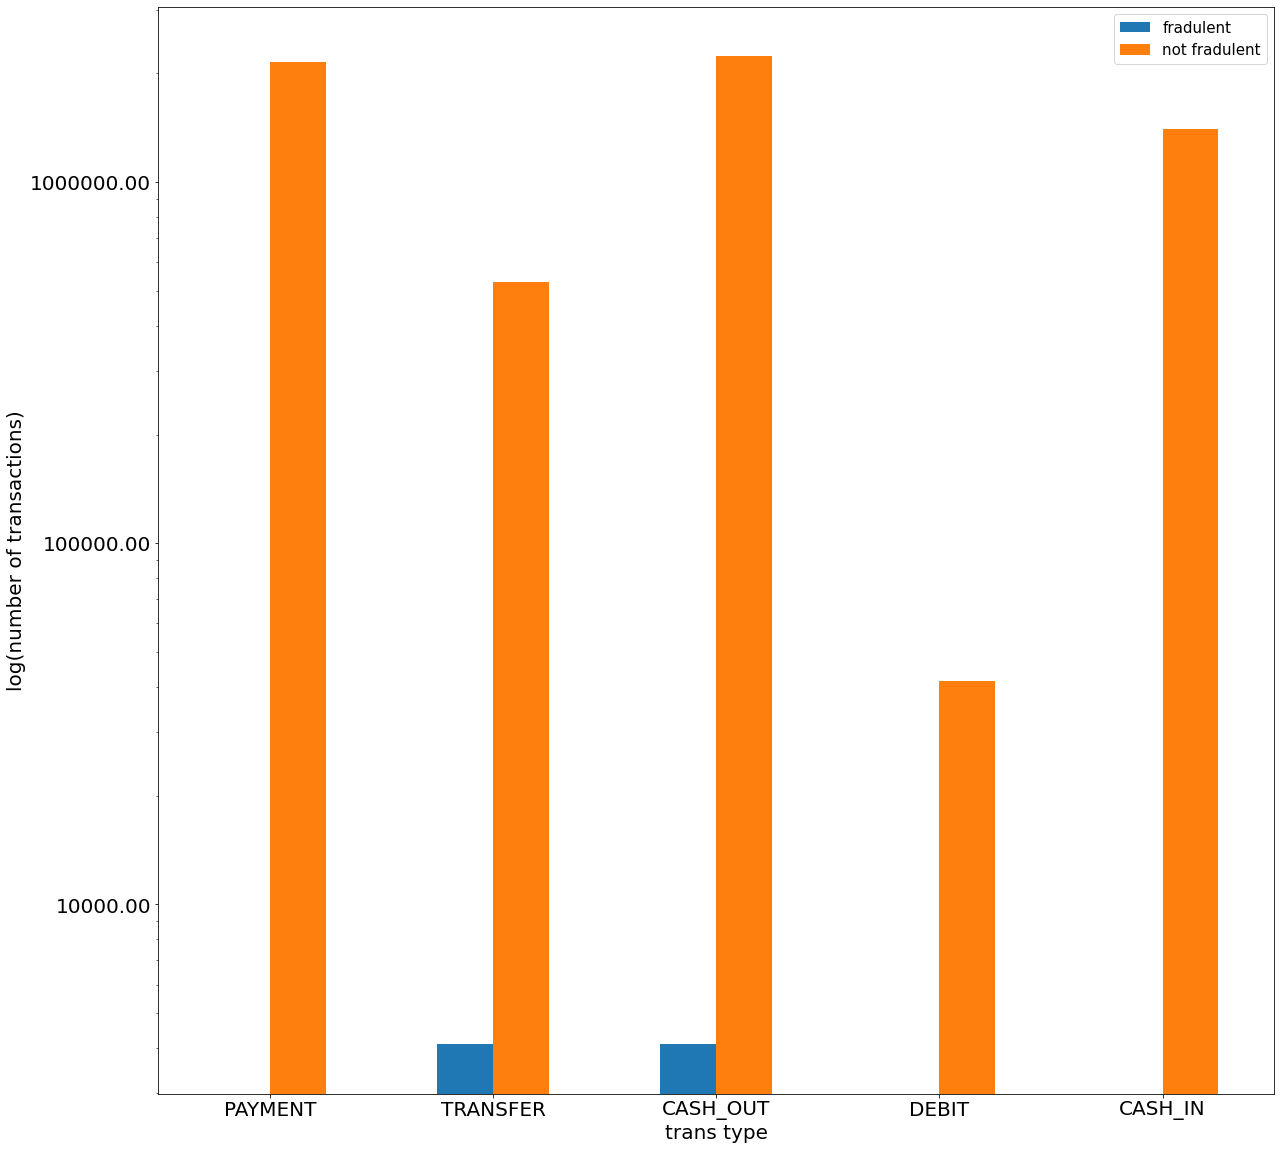

In [89]:
from matplotlib import ticker
thefinal_dict = dict(zip(col_names,rows))

myplot_df = pd.DataFrame(thefinal_dict)
myplot_df = myplot_df.set_index("type")
myplot_df.plot(kind='bar',figsize=(20,20),logy=True,fontsize=20)
#plt.figure(figsize=(20,20))
plt.ylabel("log(number of transactions)",fontsize=20)
plt.xlabel("trans type",fontsize=20)
plt.legend(["fradulent","not fradulent"],fontsize=15)
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
plt.gca().xaxis.set_tick_params(rotation=0)
plt.savefig('fraud_not_fraud_per_xfer.png')

In [25]:
#TODO If you have time - convert it to a SQL query


def calc_suspect(row):
    if ((row["oldbalanceOrg"] == row["amount"]) or (row["newbalanceDest"] == row["amount"])) and (row["newbalanceOrig"] == 0):
        row["suspicious_rating"] = 1.0
    if ((row["oldbalanceOrg"] == row["amount"]) or (row["newbalanceDest"] == row["amount"])) and (row["newbalanceOrig"] < row["oldbalanceOrg"]):
        row["suspicious_rating"] = 0.6
    else:
        row["suspicious_rating"] = 0

paysim_data_df["suspect_score"] = paysim_data_df.apply(calc_suspect,axis=1)



KeyboardInterrupt: 

In [ ]:
# Things to plot
#
# X axis 
#


Initial thought is that `isFraud` is basically a function of `type` and `amount`

one-hot-encoding `type`

In [ ]:
ohe = OneHotEncoder(sparse=False)

np_data_type = np.array(data_df["type"])
np_data_type = np_data_type.reshape(-1,1)
np_data_type.shape



In [ ]:
np_data_type_ohe = ohe.fit_transform(np_data_type)
np_data_type_ohe.shape

In [ ]:
np_data_type_ohe_df= pd.DataFrame(np_data_type_ohe,
                           columns=ohe.get_feature_names(['type']), #create meaningful column names
                           index=data_df.index) #keep the same index values

#np_data_type_ohe_df.head()

#combine continuous and categorical data

data_df = pd.concat([data_df, np_data_type_ohe_df], axis=1)
data_df.head()

A plot to help me understand how mixed together `isFraud==0` is with `isFraud==1` as a function of `type` and `amount`

In [ ]:
NUM_OF_RANDOM_SAMPLES = 6000

plot_data_df = data_df[["step","isFraud","amount","type_CASH_IN","type_CASH_OUT","type_DEBIT","type_PAYMENT","type_TRANSFER"]]
#limit to the first time step
plot_data_df = plot_data_df[ plot_data_df["step"] == 1 ]
#np_plot_data_df_indices = list(np.random.permutation(np.array(list(plot_data_df.index)))[:5000])
#sns.pairplot(plot_data_df.iloc[[np_plot_data_df_indices]], hue='isFraud');

In [ ]:
#This code is generating the index numbers for data frame plot_data_df
#then randomizing the list containing those indices
#then picking the first NUM_OF_RANDOM_SAMPLES from that list
#this list of randomly picked indices will be used to pick the corresponding
#rows out of plot_data_df to be used in the pair plot
#to plot all 6M rows is not practical (on this machine) 
plot_data_df_indices = list(plot_data_df.index)
plot_data_df_indices = np.random.permutation(plot_data_df_indices)
plot_data_df_indices = plot_data_df_indices[:NUM_OF_RANDOM_SAMPLES]
plot_data_df_indices = list(plot_data_df_indices)


In [ ]:
 plot_data_df = plot_data_df.iloc[plot_data_df_indices]

In [ ]:
plot_data_df.shape

In [ ]:
plot_data_df.head()

In [ ]:
sns.pairplot(plot_data_df, hue='isFraud');

Not looking like good parameters :(

## Baseline Model

Random Guessing (50% chance of `isFraud==1` and 50% chance that `isFraud==0` will be the baseline model

In [ ]:
data_df.shape

In [ ]:
X = data_df[["step","amount","type_CASH_IN","type_CASH_OUT","type_DEBIT","type_PAYMENT","type_TRANSFER"]]
Y = data_df["isFraud"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=TEST_SIZE, random_state=RANDOM_STATE)

number_of_test_samples = X_test.shape[0]
y_pred_zero = np.zeros(number_of_test_samples // 2)
y_pred_one = np.ones( number_of_test_samples -  y_pred_zero.shape[0] )

y_pred = np.array([y_pred_zero, y_pred_one])
y_pred = y_pred.reshape(-1,)
y_pred = np.random.permutation(y_pred)




Scoring the baseline model

In [ ]:
target_names = ["NotFraud","Fraud"]
print(classification_report(Y_test, y_pred,target_names=target_names))

Thoughts about random guessing model:

Precision (TP/(TP+FP)) and recall (TP/(TP+FN)) are high for the `NotFraud` class because most (99.97%) of the response variables in the test set are `NotFraud`. Precision and recall are very low for `Fraud` because there are very few chances to guess right and the random guessing model does not perform well in identifying them.

Accuracy is meaningless for the same reason: It's easy to get 50% right as the vast majority of the results belong to one class. 

TODO: generate confusion matrix which will help illustrate this.

## Model Selection

Just some notes about what model to select:

**Logistic Models**
For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.

Note that ‘sag’ and ‘saga’ fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from sklearn.preprocessing.



### Modeling Ideas

Try these:

* use stratified train/val/test split
* use over sampling
* use SMOTE
* use ADASYN

* I'm thinking a logistic model will work as it's a binary classification that we're trying to do. Try to ensemble this model if required
* If that doesn't work try a gradient boosted model (of logistic models)
* Do a grid search to find the right hyper parameters


## Model Evaluation

In [ ]:
#Since I'm using values that are either 1 or 0 along with amount which is a very large number, will normalize the data
#to aid gradient descent
normalizer = StandardScaler()
X_train_normal = normalizer.fit_transform(X_train.values)
X_test_normal = normalizer.transform(X_test.values)

#logisticRModel = LogisticRegressionCV(Cs=100,cv=5,solver="sag",n_jobs=-1,random_state=RANDOM_STATE)
logisticRModel = LogisticRegression(C=100,solver="sag",n_jobs=-1,random_state=RANDOM_STATE)

logisticRModel.fit(X_train_normal,Y_train)

In [ ]:
Y_pred = logisticRModel.predict(X_test_normal)

In [ ]:
print(classification_report(Y_test, Y_pred,target_names=target_names))

In [ ]:
logisticRModel.score(X_test_normal,Y_test)

In [ ]:
Y_test.value_counts()

In [ ]:
Y_pred_df = pd.DataFrame(Y_pred)
Y_pred_df.value_counts()

In [ ]:
logisticRModel.coef_

Thoughts about baseline logistic model:

Precision (TP/(TP+FP)) and recall (TP/(TP+FN)) are high for the `NotFraud` because most(99.97%) of the response variables in the test set are `NotFraud`. Precision and recall are very low for `Fraud` because there are very few chances to guess right and the random guessing model does not perform well in identify them.

Accuracy is meaningless for the same reason: It's easy to get 50% right as the vast majority of the results belong to one class. 

TODO: generate confusion matrix which will help illustrate this.